## Question

The prediction question I am trying to answer is:

###### Can we predict if a NCAA College Football QB is going to be drafted in the first round? 

To complete this analysis, I first go collecting and identifying the data needed. ESPN has one of the best compiled lists of data, including historical stats, and this is the main data I am drawing from. Using Beautiful Soup and other webscraping techniques, I was able to collect the statistics of the top 50 quarterbacks in the FBS from 2004 to 2020. Then, I found a list of all the first round picks in the same time frame and scraped that data set as well. After cleaning the data, I merged the two together to have a complete data set. I then divided up the dataset , with year 2004-2019 to be the labeled data set on which to train the model. 2020 can be used to generate prediction. Of note: Althouth the data was gathered, predictions were not yet generated at time of making this code due to their being a few weeks left in the season.  However the model was trained with Ridge, Random Forest, and Elastic Net and was scored with the accuarcy displayed.

## Web Scraping and Exporting Data

In [106]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

In [3]:
#These blocks of code were used to test out the URL and response
url = "https://www.espn.com/college-football/stats/player/_/view/offense/table/passing/sort/passingYards/dir/desc"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [21]:
header = soup.find('tr',attrs={'class' : 'Table__sub-header Table__TR Table__even'})
print(header)

<tr class="Table__sub-header Table__TR Table__even"><th class="Table__TH" title=""><span class=""><div>RK</div></span></th><th class="Table__TH" title=""><span class=""><div>Name</div></span></th></tr>


In [49]:
#Trying to parse through all the possible tables to find the headers, 
#I listed them out to easily see which ones I needed
for j in range(0,102):
    column_headers = soup.findAll('tr')[j]
    column_headers = [i.getText() for i in column_headers.findAll('th')]
    print(str(j) + ": ")
    print(column_headers)

0: 
['RK', 'Name']
1: 
[]
2: 
[]
3: 
[]
4: 
[]
5: 
[]
6: 
[]
7: 
[]
8: 
[]
9: 
[]
10: 
[]
11: 
[]
12: 
[]
13: 
[]
14: 
[]
15: 
[]
16: 
[]
17: 
[]
18: 
[]
19: 
[]
20: 
[]
21: 
[]
22: 
[]
23: 
[]
24: 
[]
25: 
[]
26: 
[]
27: 
[]
28: 
[]
29: 
[]
30: 
[]
31: 
[]
32: 
[]
33: 
[]
34: 
[]
35: 
[]
36: 
[]
37: 
[]
38: 
[]
39: 
[]
40: 
[]
41: 
[]
42: 
[]
43: 
[]
44: 
[]
45: 
[]
46: 
[]
47: 
[]
48: 
[]
49: 
[]
50: 
[]
51: 
['POS', 'CMP', 'ATT', 'CMP%', 'YDS', 'AVG', 'LNG', 'TD', 'INT', 'SACK', 'RTG']
52: 
[]
53: 
[]
54: 
[]
55: 
[]
56: 
[]
57: 
[]
58: 
[]
59: 
[]
60: 
[]
61: 
[]
62: 
[]
63: 
[]
64: 
[]
65: 
[]
66: 
[]
67: 
[]
68: 
[]
69: 
[]
70: 
[]
71: 
[]
72: 
[]
73: 
[]
74: 
[]
75: 
[]
76: 
[]
77: 
[]
78: 
[]
79: 
[]
80: 
[]
81: 
[]
82: 
[]
83: 
[]
84: 
[]
85: 
[]
86: 
[]
87: 
[]
88: 
[]
89: 
[]
90: 
[]
91: 
[]
92: 
[]
93: 
[]
94: 
[]
95: 
[]
96: 
[]
97: 
[]
98: 
[]
99: 
[]
100: 
[]
101: 
[]


In [52]:
#Getting the column headers for the individual statistics
column_headers = soup.findAll('tr')[51]
column_headers = [i.getText() for i in column_headers.findAll('th')]
column_headers

['POS', 'CMP', 'ATT', 'CMP%', 'YDS', 'AVG', 'LNG', 'TD', 'INT', 'SACK', 'RTG']

In [56]:
players = soup.find_all('tr', attrs={"class":re.compile("Table__TR Table__TR--sm Table__even")})
len(players)

100

In [91]:
#This is the code that is actually generating the dataset
#using components of the above code

#The players and their stats are technically two different tables. so the headers for each are collected
player_headers = soup.findAll('tr')[0]
player_headers = [i.getText() for i in player_headers.findAll('th')]
player_headers

column_headers = soup.findAll('tr')[51]
column_headers = [i.getText() for i in column_headers.findAll('th')]
column_headers

#initialize dataframe
QB_data = pd.DataFrame()

#For each year (Each year on different webpage)...
for year in range(2004,2021):
    player_df = pd.DataFrame()
    stats_df = pd.DataFrame()
    final_df = pd.DataFrame()
    #Dynamic URL for each web page
    url = "https://www.espn.com/college-football/stats/player/_/view/offense/season/" + str(year) + "/table/passing/sort/passingYards/dir/desc"
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    #For each player, pull the name
    players = soup.find_all('tr', attrs={"class":re.compile("Table__TR Table__TR--sm Table__even")})
    i=0
    for player in players:
        stats = [stat.get_text() for stat in player.find_all('td')]
            
        temp = pd.DataFrame(stats).transpose()
        temp.columns = player_headers
        
        player_df = pd.concat([player_df,temp], ignore_index=True)
        if i > 48:
            break
        i=i+1

    i=0
    
    #For each player, pull the stats
    for player in players:
        if i < 50:
            i=i+1
            continue
        i=i+1
        stats = [stat.get_text() for stat in player.find_all('td')]
        
        temp = pd.DataFrame(stats).transpose()
        temp.columns = column_headers
        
        stats_df = pd.concat([stats_df,temp], ignore_index=True)
    
    final_df = pd.concat([player_df,stats_df],axis=1)
    final_df["YEAR"] = year
    #Merge the two data sets together
    QB_data = pd.concat([QB_data,final_df])



In [92]:
QB_data.head(10)

,RK,Name,POS,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
0,1,Sonny CumbieTTU,QB,421,642,65.6,"4,742",7.4,80,32,18,26,138.5,2004
1,1,Timmy ChangHAW,QB,358,602,59.5,"4,258",7.1,75,37,13,15,134.8,2004
2,1,Omar JacobsBGSU,QB,309,462,66.9,"4,002",8.7,58,41,4,10,167.2,2004
3,1,Derek AndersonORST,QB,279,515,54.2,"3,615",7.0,55,29,17,37,125.1,2004
4,1,Bruce GradkowskiTOL,QB,280,399,70.2,"3,518",8.8,96,27,8,14,162.6,2004
5,1,Josh BettsM-OH,QB,268,444,60.4,"3,512",7.9,79,23,14,24,137.6,2004
6,1,Dan OrlovskyCONN,QB,288,457,63.0,"3,354",7.3,90,23,15,14,134.7,2004
7,1,Matt LeinartUSC,QB,269,412,65.3,"3,322",8.1,69,33,6,23,156.5,2004
8,1,Jason WhiteOKLA,QB,255,390,65.4,"3,205",8.2,72,35,9,9,159.4,2004
9,1,Chris LeakFLA,QB,238,399,59.6,"3,199",8.0,81,29,12,19,145.0,2004


In [113]:
QB_data.tail()

,RK,Name,POS,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
45,46,Michael Penix Jr.IU,QB,124,220,56.4,"1,645",7.5,68,14,4,7,136.5,2020
46,47,Jeff SimsGT,QB,124,226,54.9,"1,643",7.3,59,11,11,18,122.3,2020
47,48,Michael PrattTULN,QB,128,229,55.9,"1,638",7.2,52,18,5,25,137.6,2020
48,49,Max DugganTCU,QB,136,227,59.9,"1,635",7.2,71,9,4,18,130.0,2020
49,50,Alan BowmanTTU,QB,150,232,64.7,"1,602",6.9,48,10,7,2,130.8,2020


In [102]:
#This is testing the table where all 1st round draft picks are found
url2 = "http://www.drafthistory.com/index.php/rounds/round_1"
page2 = requests.get(url2)
soup = BeautifulSoup(page2.text, 'html.parser')

#This code is to find where the headers are
#draft_cols = soup.findAll('tr')
#for j in range(0,2000):
#    draft_cols = soup.findAll('tr')[j]
#    draft_cols = [i.getText() for i in draft_cols.findAll('th')]
#    print(str(j) + ": ")
#    print(draft_cols)

#Get the columns
draft_cols = soup.findAll('tr')[1]
draft_cols = [i.getText() for i in draft_cols.findAll('th')]
draft_cols

['Year', 'Round', 'Pick', 'Player', 'Name', 'Team', 'Position', 'College']

In [108]:
#This is the actual code that pulls in the data using some of the above componets

url2 = "http://www.drafthistory.com/index.php/rounds/round_1"
page2 = requests.get(url2)
soup = BeautifulSoup(page2.text, 'html.parser')

draft_cols = soup.findAll('tr')[1]
draft_cols = [i.getText() for i in draft_cols.findAll('th')]
draft_df = pd.DataFrame()

rd1pl = soup.find_all('tr', attrs={"bgcolor":re.compile("ffffff")})
for player in rd1pl:
    info = [stat.get_text() for stat in player.find_all('td')]
            
    temp = pd.DataFrame(info).transpose()
    temp.columns = draft_cols
        
    draft_df = pd.concat([draft_df,temp], ignore_index=True)


In [112]:
#Writing these data sets to csv files which are used in the project

#draft_df.to_csv("draft_df.csv")
#QB_data.to_csv("QB_data.csv")

## Data Cleaning

In [4]:
qb_stats = pd.read_csv("QB_data.csv")

First we will clean up the QB Data...

In [5]:
qb_stats.head()

,Unnamed: 0,RK,Name,POS,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
0,0,1,Sonny CumbieTTU,QB,421,642,65.6,"4,742",7.4,80,32,18,26,138.5,2004
1,1,1,Timmy ChangHAW,QB,358,602,59.5,"4,258",7.1,75,37,13,15,134.8,2004
2,2,1,Omar JacobsBGSU,QB,309,462,66.9,"4,002",8.7,58,41,4,10,167.2,2004
3,3,1,Derek AndersonORST,QB,279,515,54.2,"3,615",7.0,55,29,17,37,125.1,2004
4,4,1,Bruce GradkowskiTOL,QB,280,399,70.2,"3,518",8.8,96,27,8,14,162.6,2004


In [6]:
qb_stats.columns

Index(['Unnamed: 0', 'RK', 'Name', 'POS', 'CMP', 'ATT', 'CMP%', 'YDS', 'AVG',
       'LNG', 'TD', 'INT', 'SACK', 'RTG', 'YEAR'],
      dtype='object')

In [7]:
qb_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 15 columns):
Unnamed: 0    850 non-null int64
RK            850 non-null int64
Name          850 non-null object
POS           850 non-null object
CMP           850 non-null int64
ATT           850 non-null int64
CMP%          850 non-null float64
YDS           850 non-null object
AVG           850 non-null float64
LNG           850 non-null int64
TD            850 non-null int64
INT           850 non-null int64
SACK          850 non-null int64
RTG           850 non-null float64
YEAR          850 non-null int64
dtypes: float64(3), int64(9), object(3)
memory usage: 99.7+ KB


In [8]:
#Taking out any commas
qb_stats.replace(',','', regex=True, inplace=True)

In [9]:
qb_stats['YDS'] = qb_stats['YDS'].astype('int')

In [10]:
#Don't need rank, position for this project
qb_stats.drop(['Unnamed: 0', 'RK','POS'], axis=1,inplace=True)

In [11]:
#Used regex for cleaning and creating new variables
#Need to find a way to extract college for the name (Using capitilization to split)
pattern = '[A-Z]{2,}'
qb_stats['College'] = qb_stats['Name'].apply(lambda x:str(re.findall(pattern, x)[0]))
qb_stats['Name'] = qb_stats['Name'].apply(lambda x: x.replace((re.findall(pattern, x)[0]),""))

In [12]:
qb_stats.head()

,Name,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR,College
0,Sonny Cumbie,421,642,65.6,4742,7.4,80,32,18,26,138.5,2004,TTU
1,Timmy Chang,358,602,59.5,4258,7.1,75,37,13,15,134.8,2004,HAW
2,Omar Jacobs,309,462,66.9,4002,8.7,58,41,4,10,167.2,2004,BGSU
3,Derek Anderson,279,515,54.2,3615,7.0,55,29,17,37,125.1,2004,ORST
4,Bruce Gradkowski,280,399,70.2,3518,8.8,96,27,8,14,162.6,2004,TOL


Now we will clean the draft data to get ready to combine...

In [13]:
draft_stats = pd.read_csv("draft_df.csv")

In [14]:
draft_stats.head()

,Unnamed: 0,Year,Round,Pick,Player,Name,Team,Position,College
0,0,2020,1,1,1,Joe Burrow,Bengals,QB,Louisiana State
1,1,,1,3,3,Jeff Okudah,Lions,DB,Ohio State
2,2,,1,5,5,Tua Tagovailoa,Dolphins,QB,Alabama
3,3,,1,7,7,Derrick Brown,Panthers,DT,Auburn
4,4,,1,9,9,CJ Henderson,Jaguars,DB,Florida


In [15]:
draft_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 9 columns):
Unnamed: 0    997 non-null int64
Year          997 non-null object
Round         997 non-null int64
Pick          997 non-null int64
Player        997 non-null int64
Name          997 non-null object
Team          997 non-null object
Position      997 non-null object
College       997 non-null object
dtypes: int64(4), object(5)
memory usage: 70.2+ KB


In [16]:
#Finding where everything is year 2003 and on and dropping that data
draft_stats[draft_stats["Year"] == '2003']

,Unnamed: 0,Year,Round,Pick,Player,Name,Team,Position,College
271,271,2003,1,1,1,Carson Palmer,Bengals,QB,USC


In [17]:
draft_stats = draft_stats.loc[:270,:]

In [18]:
draft_stats.tail()

,Unnamed: 0,Year,Round,Pick,Player,Name,Team,Position,College
266,266,,1,23,23,Marcus Tubbs,Seahawks,DT,Texas
267,267,,1,25,25,Ahmad Carroll,Packers,DB,Arkansas
268,268,,1,27,27,Jason Babin,Texans,DE,Western Michigan
269,269,,1,29,29,Michael Jenkins,Falcons,WR,Ohio State
270,270,,1,31,31,Rashaun Woods,49ers,WR,Oklahoma State


In [19]:
#Just need the name, since each player plays one position and can match unique on name
draft_stats = draft_stats['Name']

In [20]:
draft_stats

0           Joe Burrow
1          Jeff Okudah
2       Tua Tagovailoa
3        Derrick Brown
4         CJ Henderson
            ...       
266       Marcus Tubbs
267      Ahmad Carroll
268        Jason Babin
269    Michael Jenkins
270      Rashaun Woods
Name: Name, Length: 271, dtype: object

Now to combine the datasets...

In [21]:
round_1 = draft_stats.to_list()

qb_stats['Round_1'] = qb_stats['Name'].apply(lambda x: True if (x in round_1) else False)

In [22]:
qb_stats.head()

,Name,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR,College,Round_1
0,Sonny Cumbie,421,642,65.6,4742,7.4,80,32,18,26,138.5,2004,TTU,False
1,Timmy Chang,358,602,59.5,4258,7.1,75,37,13,15,134.8,2004,HAW,False
2,Omar Jacobs,309,462,66.9,4002,8.7,58,41,4,10,167.2,2004,BGSU,False
3,Derek Anderson,279,515,54.2,3615,7.0,55,29,17,37,125.1,2004,ORST,False
4,Bruce Gradkowski,280,399,70.2,3518,8.8,96,27,8,14,162.6,2004,TOL,False


In [23]:
(qb_stats[qb_stats['Round_1'] == True])

,Name,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR,College,Round_1
15,Alex Smith,214,317,67.5,2952,9.3,78,32,4,18,176.5,2004,UTAH,True
26,Jason Campbell,188,270,69.6,2700,10.0,87,20,7,13,172.9,2004,AUB,True
66,Jay Cutler,273,462,59.1,3073,6.7,47,21,9,24,126.1,2005,VAN,True
67,Vince Young,212,325,65.2,3036,9.3,75,26,10,13,163.9,2005,TEX,True
97,JaMarcus Russell,188,311,60.5,2443,7.9,50,15,9,21,136.6,2005,LSU,True
112,JaMarcus Russell,232,342,67.8,3129,9.1,58,28,8,16,167.0,2006,LSU,True
251,Levi Brown,321,504,63.7,4254,8.4,70,23,9,24,146.1,2009,TROY,True
256,Blaine Gabbert,262,445,58.9,3593,8.1,84,24,9,19,140.5,2009,MIZ,True
283,Jake Locker,230,395,58.2,2800,7.1,51,21,11,28,129.7,2009,WASH,True
288,Christian Ponder,227,330,68.8,2717,8.2,98,14,7,15,147.7,2009,FSU,True


## Exploring and Dividing up Data into Test and Train

In [24]:
train = qb_stats[qb_stats['YEAR'] != 2020]
test = qb_stats[qb_stats['YEAR'] == 2020]

In [25]:
print(len(train))
print(len(test))

800
50


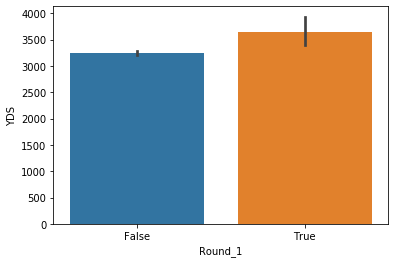

In [26]:
sns.barplot(y='YDS',x='Round_1', data=train)

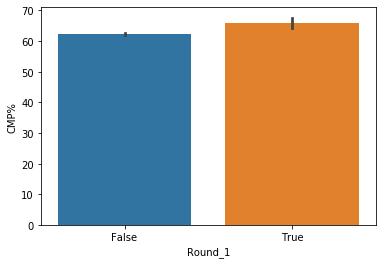

In [27]:
sns.barplot(y='CMP%',x='Round_1', data=train)

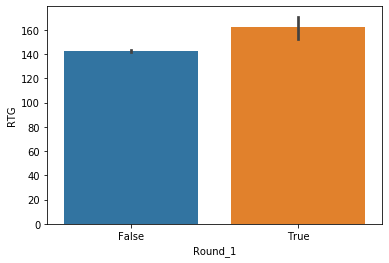

In [28]:
sns.barplot(y='RTG',x='Round_1', data=train)

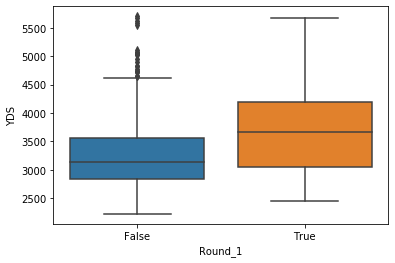

In [29]:
sns.boxplot(y='YDS',x='Round_1',data=train)

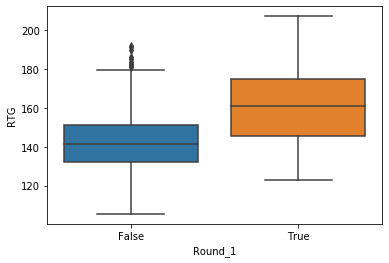

In [30]:
sns.boxplot(y='RTG',x='Round_1',data=train)

In [31]:
train.describe()

,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,261.383750,417.613750,62.467875,3266.630000,7.863875,74.181250,24.715000,10.273750,22.737500,143.212625,2011.500000
std,52.460739,71.335987,4.377063,592.732288,0.928283,11.135569,7.853558,3.647663,8.589285,15.810460,4.612656
min,162.000000,252.000000,48.500000,2222.000000,5.600000,44.000000,10.000000,2.000000,3.000000,105.500000,2004.000000
25%,226.000000,369.000000,59.400000,2842.000000,7.200000,67.000000,19.000000,8.000000,16.000000,132.475000,2007.750000
50%,250.500000,405.000000,62.400000,3136.000000,7.800000,75.000000,24.000000,10.000000,22.000000,141.750000,2011.500000
75%,287.000000,454.000000,65.450000,3576.000000,8.400000,81.000000,29.000000,13.000000,28.000000,152.125000,2015.250000
max,512.000000,714.000000,76.700000,5705.000000,11.600000,99.000000,60.000000,23.000000,54.000000,206.900000,2019.000000


In [32]:
train[train["Round_1"] == True].describe()

,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,270.516129,411.709677,65.787097,3656.451613,8.990323,74.193548,30.193548,8.161290,21.709677,162.080645,2012.225806
std,57.801310,82.262261,4.962979,759.640654,1.429068,13.115943,10.565413,3.088654,8.331441,24.603583,4.786855
min,180.000000,252.000000,56.000000,2443.000000,6.600000,47.000000,14.000000,3.000000,6.000000,123.200000,2004.000000
25%,228.500000,356.500000,62.600000,3054.500000,8.150000,67.500000,22.000000,6.000000,15.500000,145.500000,2009.000000
50%,262.000000,395.000000,67.200000,3665.000000,8.900000,76.000000,31.000000,8.000000,23.000000,161.100000,2013.000000
75%,303.500000,477.500000,69.000000,4198.500000,9.750000,84.000000,36.500000,9.500000,27.500000,174.900000,2016.000000
max,408.000000,564.000000,76.300000,5671.000000,11.600000,98.000000,60.000000,15.000000,39.000000,206.900000,2019.000000


In [71]:
train[train["Round_1"] == False].describe()

,CMP,ATT,CMP%,YDS,AVG,LNG,TD,INT,SACK,RTG,YEAR
count,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000,769.000000
mean,261.015605,417.851756,62.334070,3250.915475,7.818466,74.180754,24.494148,10.358908,22.778934,142.452016,2011.470741
std,52.241823,70.911413,4.302002,580.164324,0.873747,11.058313,7.651612,3.644513,8.602206,14.881717,4.606324
min,162.000000,257.000000,48.500000,2222.000000,5.600000,44.000000,10.000000,2.000000,3.000000,105.500000,2004.000000
25%,226.000000,370.000000,59.400000,2838.000000,7.200000,67.000000,19.000000,8.000000,16.000000,132.200000,2007.000000
50%,250.000000,405.000000,62.300000,3131.000000,7.700000,75.000000,24.000000,10.000000,22.000000,141.200000,2011.000000
75%,286.000000,453.000000,65.300000,3557.000000,8.400000,81.000000,29.000000,13.000000,28.000000,151.100000,2015.000000
max,512.000000,714.000000,76.700000,5705.000000,11.300000,99.000000,58.000000,23.000000,54.000000,191.800000,2019.000000


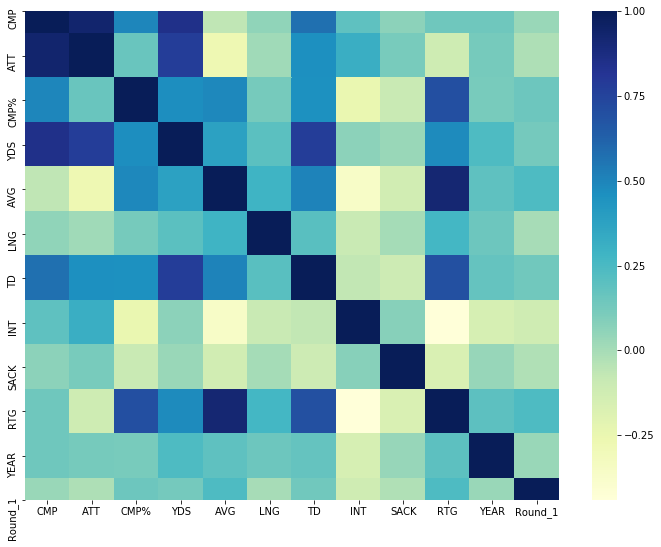

In [80]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square = True, cmap="YlGnBu")

## Building the models

In [52]:
X = train.drop(['Name', "Round_1","College"], axis = 1)
y = train['Round_1']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

#### Using Ridge

In [81]:
ridgecv = RidgeClassifierCV(cv=5).fit(X_train, np.ravel(y_train))
ridge_cv_alpha=RidgeClassifier(alpha = ridgecv.alpha_,max_iter=100000,random_state=0).fit(X_train,y_train)

print("Ridge accuracy on training set: {:.3f}".format(ridge_cv_alpha.score(X_train, y_train)))
print("Ridge accuracy on test set: {:.3f}".format(ridge_cv_alpha.score(X_test, y_test)))

Ridge accuracy on training set: 0.962
Ridge accuracy on test set: 0.960


#### Using Random Forest

In [107]:
grid = {'min_samples_leaf': [1,2,3,4,5],
       'max_depth' : [1,2,3,4,5,6,7,8,9]}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0),grid,cv=5,return_train_score=True)
best_model=grid_search.fit(X_train,y_train)

print("RF accuracy on training set: {:.3f}".format(best_model.score(X_train, y_train)))
print("RF accuracy on test set: {:.3f}".format(best_model.score(X_test, y_test)))

RF accuracy on training set: 0.972
RF accuracy on test set: 0.960


#### Using KNN Classifier

In [86]:
grid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_search = GridSearchCV(KNeighborsClassifier(),grid,cv=5,return_train_score=True)
best_model_knn=grid_search.fit(X_train,y_train)

print("KNN accuracy on training set: {:.3f}".format(best_model.score(X_train, y_train)))
print("KNN accuracy on test set: {:.3f}".format(best_model.score(X_test, y_test)))

KNN accuracy on training set: 0.967
KNN accuracy on test set: 0.960


All models have similar out of sample accuuacy, moving forward with the Random Forest model...

In [123]:
yhat = best_model.predict(X_test)

In [124]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [129]:
probabilities = best_model.predict_proba(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, y_prob)

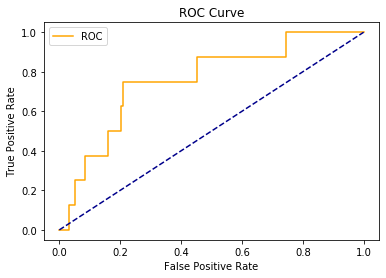

In [130]:
#Here is the ROC curve, due to the limited amount of test data we get a step like curve
plot_roc_curve(fpr, tpr)

In [131]:
roc_auc_score(y_test, y_prob)

0.7578125

#### Conclusion and Limitations

Based of the models, we do have some success in predicting if a quarteback is a future first round pick. The major limitation is the limited number of observations that did go in the first round, which could possibly be fixed in future projects. The reason is that ESPN includes QB stats back to 2004, however the first round draft picks date back to the 1930's, forcing us to get rid a lot of potential positive observations. I am sure the data is out there, but it would likely have to be hand collected and is beyond the time scope of this project. However, there are differences in the first rounders and non firstrounders that the model is picking up on. No one observation is enough to decide if someone is good enough for the first round, and there is some inherit variance due to the fact that sometimes teams take QB's in the first round because they are desperate for a QB, even if the QB isn't clear first round material. I would love to keep looking for more data and building off this with time.